In [1]:
import pandas as pd
import numpy as np

# Load the data
file_path = 'simulated_transaction_2024.csv'
df = pd.read_csv(file_path)

# Convert 'Date' and 'Timestamp' into datetime
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Timestamp'], format='%d/%m/%Y %H:%M')

# Clean up Account No fields
df['Account No'] = df['Account No'].apply(lambda x: str(x).split('.')[0] if pd.notnull(x) else x)
df['Third Party Account No'] = df['Third Party Account No'].apply(lambda x: str(x).split('.')[0] if pd.notnull(x) else x)

# Handling NaN values - Example: fill NaN with a placeholder or median (depending on the context)
df['Third Party Account No'].fillna('Unknown', inplace=True)
df['Third Party Name'].fillna('Unknown', inplace=True)

# Feature Engineering
df['Day of Week'] = df['DateTime'].dt.day_name()
df['Hour of Day'] = df['DateTime'].dt.hour

# Example of a rule-based filter for large transactions
threshold = df['Amount'].quantile(0.99)  # 99th percentile
suspect_transactions = df[df['Amount'] >= threshold]

print(suspect_transactions)


C:\Users\carlo\AppData\Local\Temp\ipykernel_18076\3976200855.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


              Date Timestamp Account No       Balance   Amount  \
5       01/01/2023     00:00  203466392   4607.660000  2841.66   
15      01/01/2023     00:00  832564361   5376.000000  3542.00   
24      01/01/2023     00:00  865748375   4607.000000  2773.00   
27      01/01/2023     00:00  522188082   3611.000000  2780.00   
29      01/01/2023     00:00  616924659   4292.000000  2780.00   
...            ...       ...        ...           ...      ...   
222454  01/12/2023     00:00  851649498  10809.439684  2999.00   
222463  01/12/2023     00:00  355940285  11189.705978  3333.33   
222467  01/12/2023     00:00  633345190   8469.227625  3080.00   
222471  01/12/2023     00:00  858989281  31846.289332  5292.80   
222498  01/12/2023     00:00  822135975  14112.516047  3087.75   

       Third Party Account No    Third Party Name   DateTime Day of Week  \
5                     Unknown    Lavender Primary 2023-01-01      Sunday   
15                    Unknown     Premier Finance 2023-

C:\Users\carlo\AppData\Local\Temp\ipykernel_18076\3976200855.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Third Party Account No'].fillna('Unknown', inplace=True)
C:\Users\carlo\AppData\Local\Temp\ipykernel_18076\3976200855.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [2]:
from scipy import stats

# Z-Score for 'Amount' column
df['Z-Score'] = stats.zscore(df['Amount'])
anomalies_z = df[(df['Z-Score'] > 3) | (df['Z-Score'] < -3)]

# IQR for 'Amount' column
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
anomalies_iqr = df[(df['Amount'] < Q1 - 1.5 * IQR) | (df['Amount'] > Q3 + 1.5 * IQR)]

print("Anomalies detected by Z-Score:", anomalies_z[['DateTime', 'Account No', 'Amount', 'Z-Score']])
print("Anomalies detected by IQR:", anomalies_iqr[['DateTime', 'Account No', 'Amount']])


Anomalies detected by Z-Score: Empty DataFrame
Columns: [DateTime, Account No, Amount, Z-Score]
Index: []
Anomalies detected by IQR:                   DateTime Account No   Amount
0      2023-01-01 00:00:00  678330503  1584.00
1      2023-01-01 00:00:00  472213568  1950.00
2      2023-01-01 00:00:00  472213568  -780.00
3      2023-01-01 00:00:00  283027736   780.00
4      2023-01-01 00:00:00  624500124  1825.00
...                    ...        ...      ...
230505 2023-12-06 17:54:00  370757362  -231.97
230519 2023-12-06 18:08:00  758885184  -202.99
230532 2023-12-06 18:31:00  701070224  -280.26
230539 2023-12-06 18:37:00  128033695  -216.29
230566 2023-12-06 19:28:00  146909202  -194.60

[28533 rows x 3 columns]


In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

# Load the data
file_path = 'simulated_transaction_2024.csv'
df = pd.read_csv(file_path)

# Convert 'Date' and 'Timestamp' into datetime
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Timestamp'], format='%d/%m/%Y %H:%M')

# Clean up Account No fields
df['Account No'] = df['Account No'].apply(lambda x: str(x).split('.')[0] if pd.notnull(x) else x)
df['Third Party Account No'] = df['Third Party Account No'].apply(lambda x: str(x).split('.')[0] if pd.notnull(x) else x)

# Handling NaN values
df['Balance'].fillna(df['Balance'].median(), inplace=True)
df['Amount'].fillna(df['Amount'].median(), inplace=True)

# Feature scaling for clustering
features = df[['Balance', 'Amount']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(features_scaled)
centroids = kmeans.cluster_centers_

# Identifying anomalies as transactions far from the centroids
distances = kmeans.transform(features_scaled)
df['Distance from Centroid'] = np.min(distances, axis=1)
outliers_kmeans = df[df['Distance from Centroid'] > np.percentile(df['Distance from Centroid'], 95)]


print("Outliers detected by K-Means:", outliers_kmeans[['DateTime', 'Account No', 'Amount', 'Distance from Centroid']])


C:\Users\carlo\AppData\Local\Temp\ipykernel_18076\3979367658.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Balance'].fillna(df['Balance'].median(), inplace=True)
C:\Users\carlo\AppData\Local\Temp\ipykernel_18076\3979367658.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

Outliers detected by K-Means:                   DateTime Account No   Amount  Distance from Centroid
0      2023-01-01 00:00:00  678330503  1584.00                1.468604
3      2023-01-01 00:00:00  283027736   780.00                1.630712
8      2023-01-01 00:00:00  215404070   780.00                1.634087
9      2023-01-01 00:00:00  456221621  1675.00                1.298501
12     2023-01-01 00:00:00  455831435  1620.10                1.389710
...                    ...        ...      ...                     ...
230504 2023-12-06 17:52:00  547010927   -21.35                1.185576
230557 2023-12-06 19:02:00  795847804    -5.45                1.113282
230577 2023-12-06 20:01:00  858989281    -2.49                1.713379
230587 2023-12-06 20:40:00  975345315   -73.71                3.681340
230591 2023-12-06 20:54:00  581655972   -41.06                4.616096

[11530 rows x 4 columns]


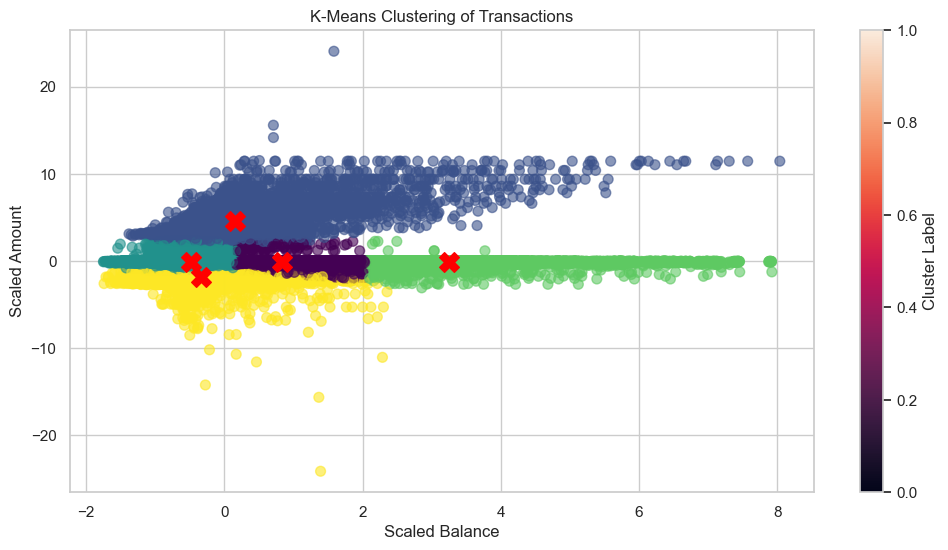

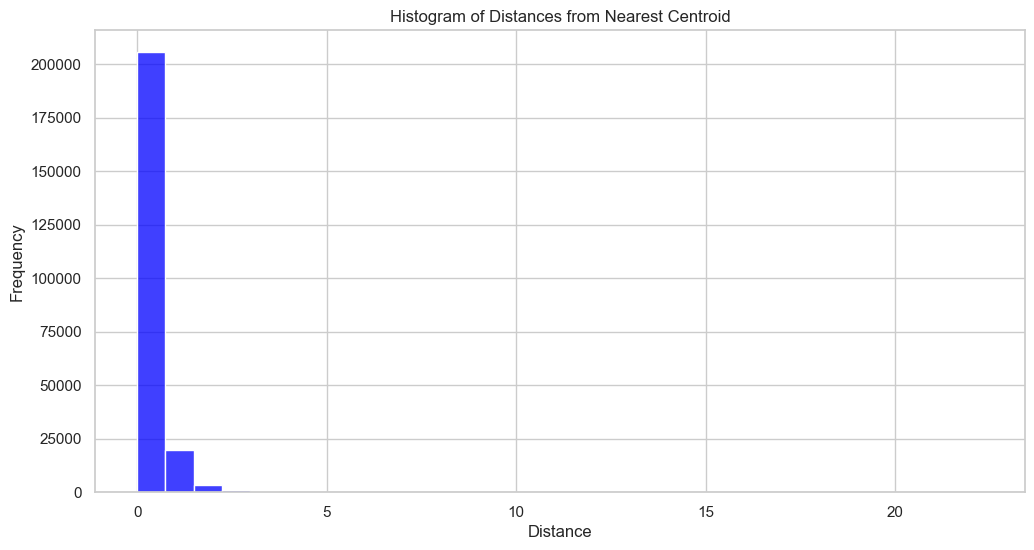

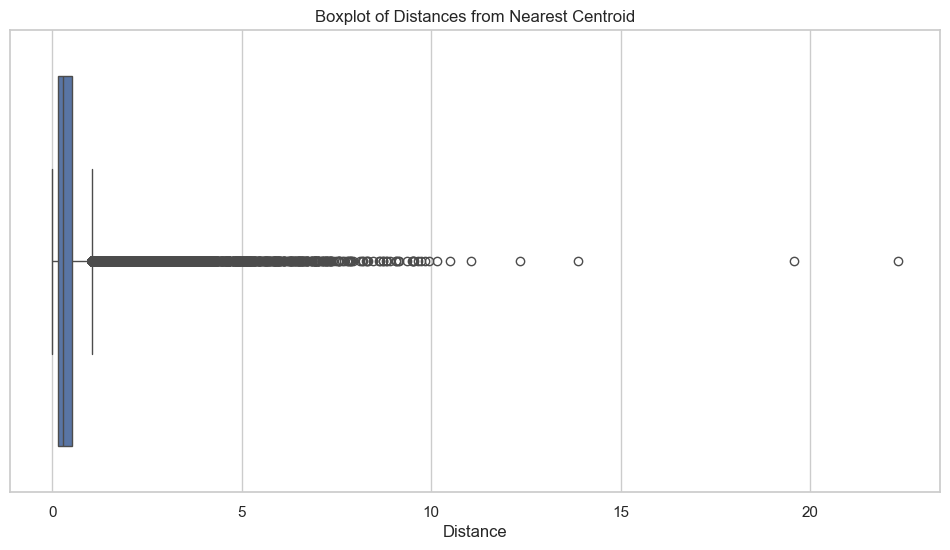

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style='whitegrid')

# Prepare the data
features = df[['Balance', 'Amount']]
features_scaled = scaler.transform(features)  # Assuming 'scaler' and 'features' are already defined from previous steps

# Plotting K-Means Clusters
plt.figure(figsize=(12, 6))
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=df['Cluster'], cmap='viridis', s=50, alpha=0.6)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X')  # Mark centroids
plt.title('K-Means Clustering of Transactions')
plt.xlabel('Scaled Balance')
plt.ylabel('Scaled Amount')
plt.colorbar(label='Cluster Label')
plt.show()

# Histogram of Distances from Centroid
plt.figure(figsize=(12, 6))
sns.histplot(df['Distance from Centroid'], bins=30, kde=False, color='blue')
plt.title('Histogram of Distances from Nearest Centroid')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

# Boxplot for Anomaly Detection
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Distance from Centroid'])
plt.title('Boxplot of Distances from Nearest Centroid')
plt.xlabel('Distance')
plt.show()


In [5]:
from sklearn.ensemble import IsolationForest

# Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['IsolationForest Score'] = iso_forest.fit_predict(features_scaled)

# Identifying anomalies detected by Isolation Forest
anomalies_iso_forest = df[df['IsolationForest Score'] == -1]



print("Anomalies detected by Isolation Forest:", anomalies_iso_forest[['DateTime', 'Account No', 'Amount']])


Anomalies detected by Isolation Forest:                   DateTime Account No   Amount
15     2023-01-01 00:00:00  832564361  3542.00
41     2023-01-01 00:00:00  298000165  4167.00
46     2023-01-01 00:00:00  183888402  4167.00
57     2023-01-01 00:00:00  414805878  3087.75
67     2023-01-01 00:00:00  705848712  5292.80
...                    ...        ...      ...
230213 2023-12-06 07:22:00  558119802   -22.52
230257 2023-12-06 08:39:00  639409800    -9.20
230498 2023-12-06 17:48:00  386729293   -49.98
230587 2023-12-06 20:40:00  975345315   -73.71
230591 2023-12-06 20:54:00  581655972   -41.06

[2306 rows x 3 columns]


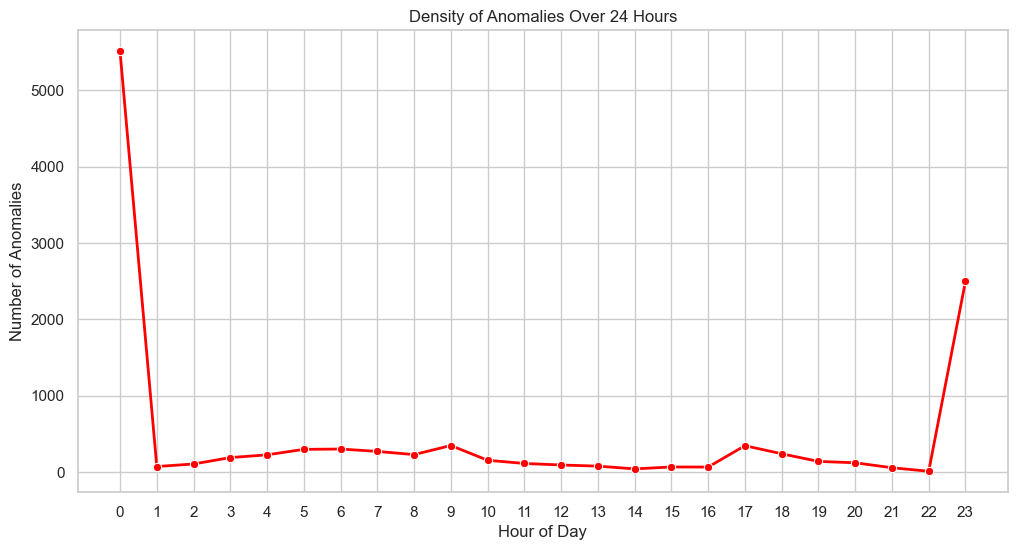

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' already contains a column 'Distance from Centroid' from the K-Means results
# Identify anomalies as those beyond the 95th percentile of distance
threshold = np.percentile(df['Distance from Centroid'], 95)
df['Anomaly'] = df['Distance from Centroid'] > threshold

# Extract hour from DateTime
df['Hour'] = df['DateTime'].dt.hour

# Calculate the count of anomalies per hour
hourly_anomalies = df[df['Anomaly']].groupby('Hour').size()

# Prepare a full range of hours to ensure the plot covers 0 to 23 hours, even if some hours have no anomalies
all_hours = pd.DataFrame(index=range(24), columns=['Anomalies'])
all_hours['Anomalies'] = hourly_anomalies
all_hours.fillna(0, inplace=True)

# Plotting the density of anomalies over 24 hours
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_hours, x=all_hours.index, y='Anomalies', marker='o', color='red', linewidth=2)
plt.title('Density of Anomalies Over 24 Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Anomalies')
plt.xticks(range(0, 24))  # Ensure ticks for every hour
plt.grid(True)
plt.show()


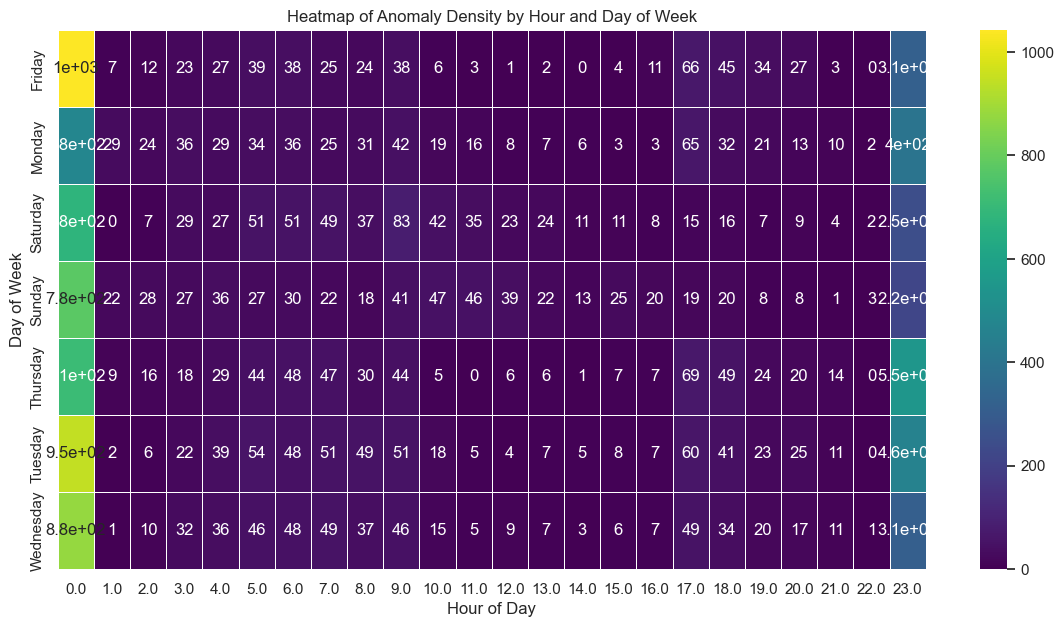

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' already contains 'DateTime' and 'Anomaly' columns
df['Hour'] = df['DateTime'].dt.hour
df['Day of Week'] = df['DateTime'].dt.day_name()

# Creating a pivot table for the heatmap
heatmap_data = pd.pivot_table(df[df['Anomaly']], values='Anomaly', 
                              index='Day of Week', 
                              columns='Hour', 
                              aggfunc='sum', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(heatmap_data, cmap='viridis', linewidths=.5, annot=True)
plt.title('Heatmap of Anomaly Density by Hour and Day of Week')
plt.ylabel('Day of Week')
plt.xlabel('Hour of Day')
plt.show()



<Figure size 1200x600 with 0 Axes>

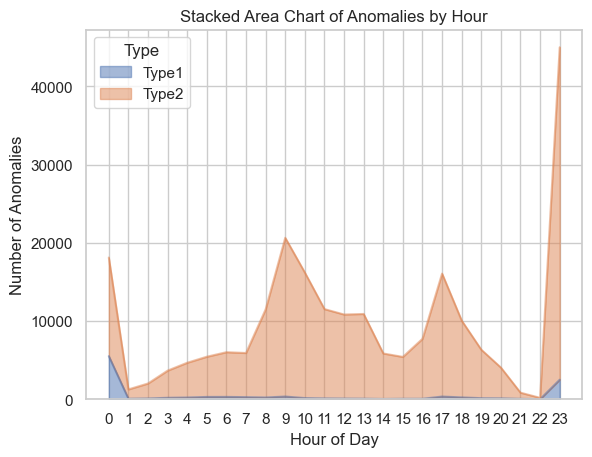

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Example of different types of anomalies classified as Type1, Type2, etc.
# You would first need to classify anomalies into different types or categories.
df['Type'] = np.where(df['Distance from Centroid'] > threshold, 'Type1', 'Type2')  # Simplified example

# Grouping data by hour and type
grouped_data = df.groupby(['Hour', 'Type']).size().unstack(fill_value=0)

# Plotting a stacked area chart
plt.figure(figsize=(12, 6))
grouped_data.plot(kind='area', stacked=True, alpha=0.5)
plt.title('Stacked Area Chart of Anomalies by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Anomalies')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


KeyboardInterrupt: 

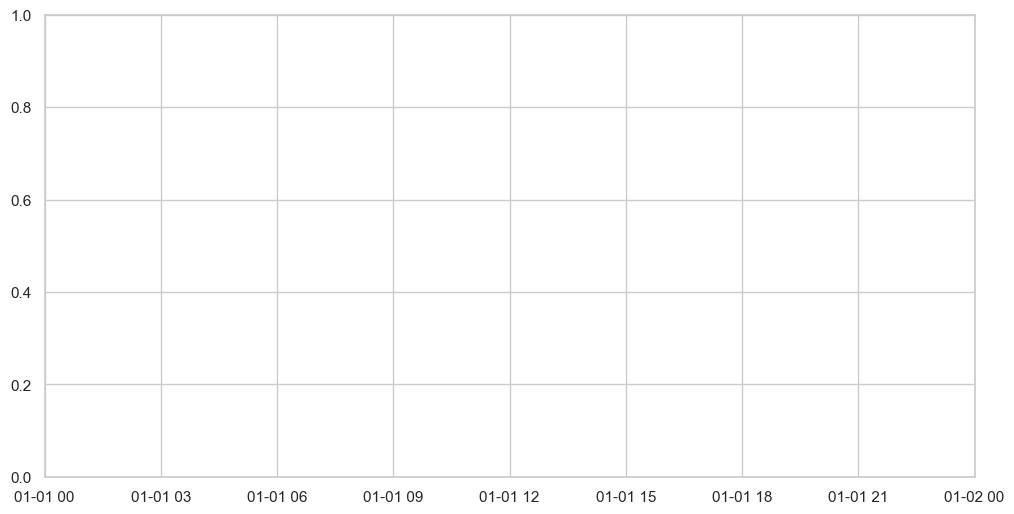

In [9]:
# Calculate a rolling threshold based on the past 30 days
rolling_threshold = df['Distance from Centroid'].rolling(window=720, min_periods=1).quantile(0.95)
df['Dynamic Anomaly'] = df['Distance from Centroid'] > rolling_threshold

# Plotting dynamic threshold effectiveness
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='DateTime', y='Dynamic Anomaly', color='green')
plt.title('Dynamic Anomaly Detection Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Anomaly Detected (1=True, 0=False)')
plt.show()
